### Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

### Download FAANG  data

In [2]:
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start_date = '2020-01-01'
end_date = '2024-01-01'

# We’re downloading Adjusted Close prices, which factor in stock splits and dividends — ensuring accurate return calculations.
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
data.dropna(inplace=True)
data.head()


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-02,72.620850,94.900497,68.026016,208.635422,329.809998
2020-01-03,71.914818,93.748497,67.670158,207.531479,325.899994
2020-01-06,72.487846,95.143997,69.473846,211.440048,335.829987
2020-01-07,72.146935,95.343002,69.339645,211.897522,330.750000
2020-01-08,73.307518,94.598503,69.833191,214.045731,339.260010


### Compute daily returns

In [3]:
daily_returns = data.pct_change().dropna() # Computes the fractional change from the immediately previous row by default
daily_returns.head()


Ticker,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-03,-0.009722,-0.012139,-0.005231,-0.005291,-0.011855
2020-01-06,0.007968,0.014886,0.026654,0.018834,0.030469
2020-01-07,-0.004703,0.002092,-0.001932,0.002164,-0.015127
2020-01-08,0.016086,-0.007809,0.007118,0.010138,0.025729
2020-01-09,0.021241,0.004799,0.010498,0.014311,-0.010611


### Construct equal-weighted portfolio

In [4]:
weights = np.array([1/5] * 5)
portfolio_daily_returns = daily_returns.dot(weights) # weighted mean, in this case weights are equal so this gives mean
portfolio_cum_returns = (1 + portfolio_daily_returns).cumprod()


### Visualize Returns dynamically using plotly

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_cum_returns.index, y=portfolio_cum_returns, name='FAANG Portfolio'))
fig.update_layout(title='Cumulative Return of Equal-Weighted FAANG Portfolio',xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()


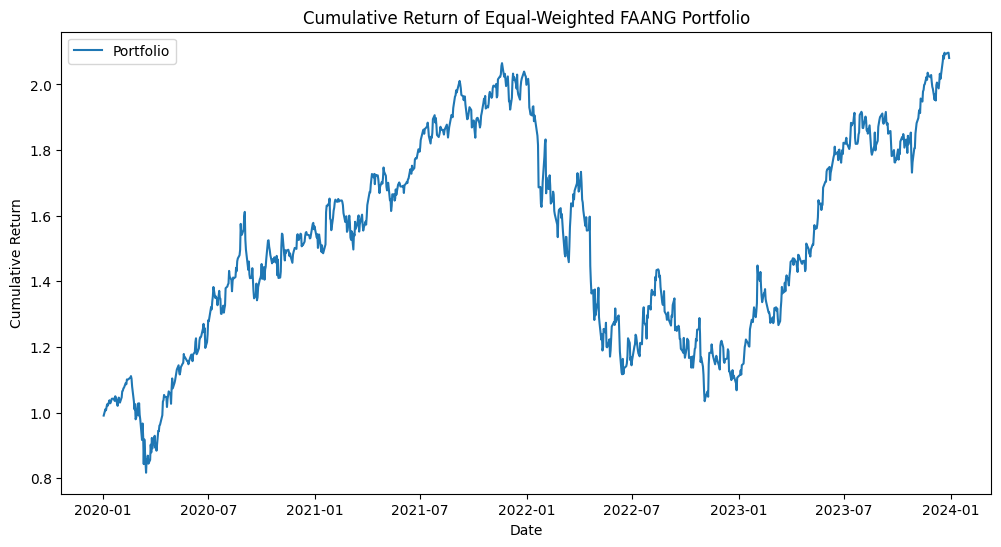

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum_returns, label='Portfolio')
plt.title('Cumulative Return of Equal-Weighted FAANG Portfolio')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()


### Compute Risk Metrics

In [7]:
trading_days = 252 # Annualization factor (252 trading days)

mean_return = portfolio_daily_returns.mean() * trading_days
volatility = portfolio_daily_returns.std() * np.sqrt(trading_days)
sharpe_ratio = mean_return / volatility

print(f"Annual Return: {mean_return:.2%}")
print(f"Annual Volatility: {volatility:.2%}")
print(f"Sharpe Ratio (Rf = 0): {sharpe_ratio:.2f}")


Annual Return: 23.74%
Annual Volatility: 32.69%
Sharpe Ratio (Rf = 0): 0.73


### Rolling Metrics

In [8]:
rolling_vol = portfolio_daily_returns.rolling(window=30).std() * np.sqrt(trading_days)
rolling_return = portfolio_daily_returns.rolling(window=30).mean() * trading_days

fig = go.Figure()
fig.add_trace(go.Scatter(x=rolling_vol.index, y=rolling_vol, name='30-Day Rolling Volatility'))
fig.update_layout(title='30-Day Rolling Annualized Volatility', xaxis_title='Date', yaxis_title='Volatility')
fig.show()



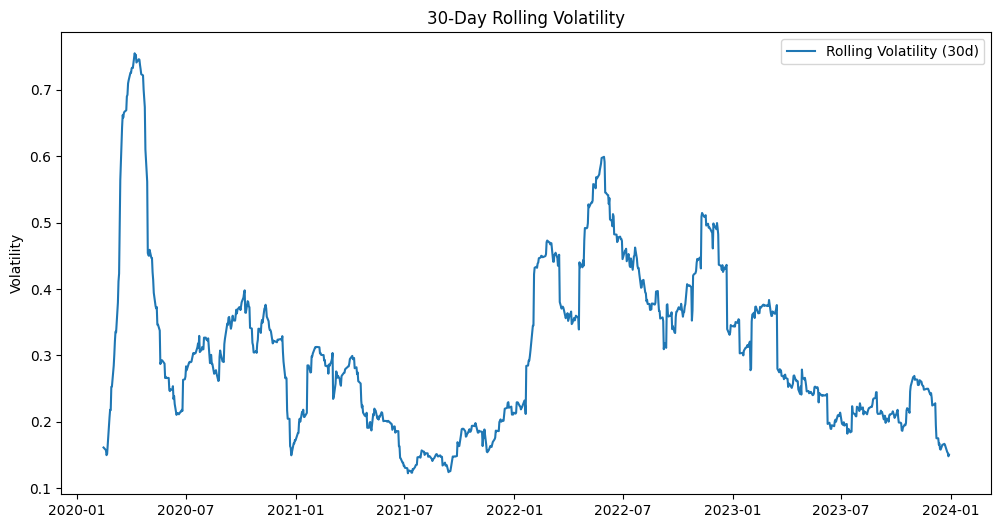

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_vol, label='Rolling Volatility (30d)')
plt.title("30-Day Rolling Volatility")
plt.ylabel("Volatility")
plt.legend()
plt.show()


### Max Drawdown

In [10]:
rolling_max = portfolio_cum_returns.cummax()
drawdown = portfolio_cum_returns / rolling_max - 1

max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=drawdown.index, y=drawdown, name='Drawdown'))
fig.update_layout(title='Drawdown Over Time', xaxis_title='Date', yaxis_title='Drawdown')
fig.show()



Maximum Drawdown: -49.88%


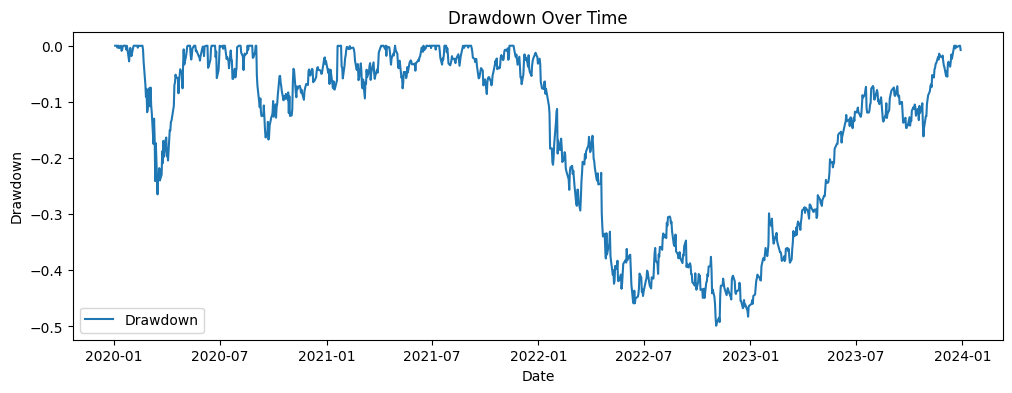

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(drawdown, label='Drawdown')
plt.title("Drawdown Over Time")
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.legend()
plt.show()

### Compare with S&P 500

In [12]:
benchmark = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=False)['Adj Close']
benchmark_returns = benchmark.pct_change().dropna().mean(axis=1)
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_cum_returns.index, y=portfolio_cum_returns,name='FAANG Portfolio'))
fig.add_trace(go.Scatter(x=benchmark_cum_returns.index,y=benchmark_cum_returns,name='S&P 500'))
fig.update_layout(title='FAANG Portfolio vs S&P 500',xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()


[*********************100%***********************]  1 of 1 completed


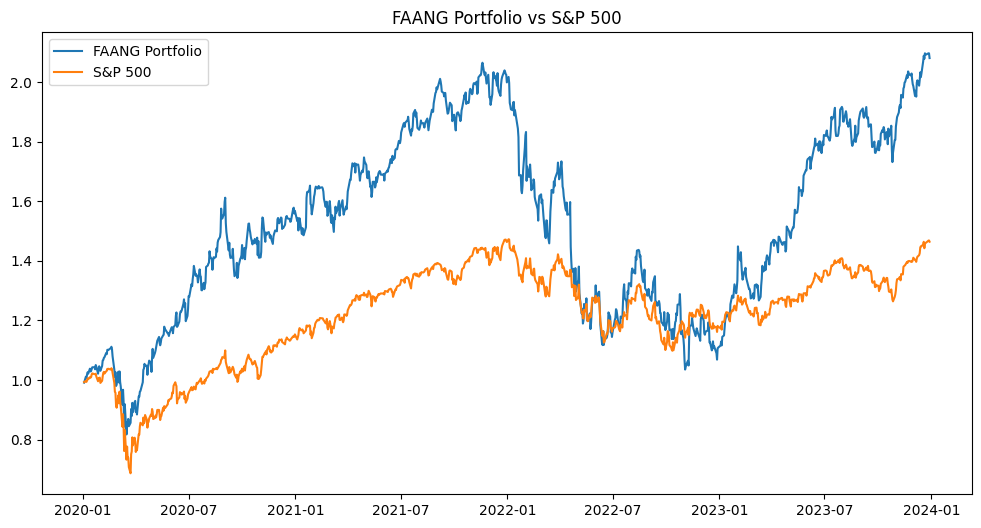

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum_returns, label='FAANG Portfolio')
plt.plot(benchmark_cum_returns, label='S&P 500')
plt.title("FAANG Portfolio vs S&P 500")
plt.legend()
plt.show()

### Summary

In [14]:
metrics = {
    'Annual Return': mean_return,
    'Annual Volatility': volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown
}

summary_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
print(summary_df)


                      Value
Annual Return      0.237359
Annual Volatility  0.326861
Sharpe Ratio       0.726176
Max Drawdown      -0.498755


| Metric                           | Formula                                                                           | Definition                                                           | Use                                                   |
| ----------------------------------- | ------------------------------------------------------------------------------------ | ----------------------------------------------------------------------- | -------------------------------------------------------- |
| **Daily Return**                    | $R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$ or $R_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$ | The percent change in price from the previous day to today.             | Measures daily movement of a stock or portfolio.         |
| **Cumulative Return**               | $CR_t = \prod_{i=1}^{t} (1 + R_i)$                                                   | Total return earned over a period by compounding daily returns.         | Tracks how much value has grown from the start.          |
| **Portfolio Return** (equal weight) | $R_{portfolio,t} = \sum_{i=1}^{n} w_i R_{i,t}$ where $w_i = \frac{1}{n}$             | Weighted average of asset returns on day $t$.                           | Measures portfolio-level performance.                    |
| **Annual Return**                   | $\bar{R}_{annual} = \bar{R}_{daily} \times 252$                                      | Scales average daily return to an annual level (252 trading days/year). | Understand long-term return rate of portfolio.           |
| **Annualized Volatility**           | $\sigma_{annual} = \sigma_{daily} \times \sqrt{252}$                                 | Standard deviation of returns scaled to annual frequency.               | Measures risk or uncertainty of portfolio returns.       |
| **Sharpe Ratio**                    | $S = \frac{E[R] - R_f}{\sigma} \approx \frac{E[R]}{\sigma}$ (if $R_f = 0$)           | Risk-adjusted return, comparing average return to volatility.           | Evaluate reward per unit of risk taken.                  |
| **Rolling Volatility**              | $\sigma_{rolling}(t) = \text{std}(R_{t-w:t}) \times \sqrt{252}$                      | Volatility calculated over a rolling window of $w$ days.                | Detect changing risk trends in portfolio.                |
| **Drawdown**                        | $D_t = \frac{P_t - \max(P_0, ..., P_t)}{\max(P_0, ..., P_t)}$                        | Percent drop from the peak portfolio value so far.                      | Measures depth of losses — critical for risk management. |
| **Max Drawdown**                    | $\min(D_t)$                                                                          | The largest observed drop from peak to trough.                          | Key indicator of worst-case downside risk.               |
